<center><br><font size=8>Machine Leaning Final Project</font><br>
<font size=6>Malware Files Detection</font>
<br><br>
<b>Introduction to Machine Learning – Digital Sciences for High-Tech, Spring 2023</b>

<b>Authors</b>: Sophie Margolis and Jeremy Sprung<br>

In our project, we focused on analyzing Portable Executable (PE) files, which are versatile executable file formats used in different operating systems, including Windows. Our primary goal is to develop a binary classifier capable of effectively distinguishing between malicious and benign files. To achieve that we explored the 23 features within our dataset, using advanced techniques and models to examine a collection of 60,000 distinct files and identify patterns indicative of malware behavior.

## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn.metrics import roc_curve
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

## Part 1: Exploratory Data Analysis

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv("test.csv")

Let's have a look at the data:

In [3]:
pd.set_option('display.max_columns', None)
train_data.head()

sha256     size      vsize  \
0  a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...  6744064  6799360.0   
1  ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...    22016    45056.0   
2  b0b126adc73b980a114e38027b082d149fcf491547452f...   686136   704512.0   
3  ff6176c53ca9b58040c93870c264843b93b5e290c28e57...     8192    36864.0   
4  59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...   396288   421888.0   

   imports  exports  has_debug  has_relocations  has_resources  has_signature  \
0    524.0      3.0        0.0              1.0            1.0            0.0   
1      2.0      0.0        0.0              0.0            1.0            0.0   
2    133.0      4.0        1.0              1.0            1.0            1.0   
3      6.0      0.0        0.0              0.0            0.0            0.0   
4    133.0      0.0        1.0              1.0            1.0            0.0   

   has_tls  symbols  numstrings  paths  urls  registry    MZ  printables  \
0      1.0      0.0     64882.0    0.0   0.0       0.0  28.0    899075.0   
1      0.0      0.0        89.0    0.0   0.0       0.0   1.0       856.0   
2      0.0      0.0      2699.0    0.0  32.0       0.0   2.0     32767.0   
3      0.0      NaN        71.0    0.0   0.0       0.0   1.0       678.0   
4      0.0      0.0      4729.0    0.0   0.0       0.0   5.0     35881.0   

    avlength                            file_type_trid  file_type_prob_trid  \
0  13.857079  Win32 EXE PECompact compressed (generic)                 64.2   
1   9.617978      Win32 Dynamic Link Library (generic)                 38.4   
2  12.140422                Win64 Executable (generic)                 82.0   
3   9.549296                Win64 Executable (generic)                 28.0   
4   7.587439                Win64 Executable (generic)                 32.2   

          A         B    C  label  
0 -3.978981  5.732354   er      1  
1  7.064133  5.738201   er      0  
2  1.052727  5.722733  gow      0  
3  2.217531  5.896053   vh      1  
4  9.401164       NaN   vh      1

In [4]:
print(f"Shape of the whole dataset:{train_data.shape}")

Shape of the whole dataset:(60000, 24)


Our data contains 60K samples and 23 features and label column.

**Statistics**

In [5]:
train_data.describe().round(3)

size         vsize    imports    exports  has_debug  \
count  6.000000e+04  5.806500e+04  58261.000  57907.000  57073.000   
mean   1.501019e+06  1.965704e+06    106.196     30.803      0.404   
std    4.727391e+06  2.017881e+07    213.452    508.080      0.491   
min    2.980000e+02  5.440000e+02      0.000      0.000      0.000   
25%    1.070080e+05  1.228800e+05      1.000      0.000      0.000   
50%    4.833280e+05  4.218880e+05     28.000      0.000      0.000   
75%    1.239326e+06  1.601536e+06    152.000      0.000      1.000   
max    3.253537e+08  4.278288e+09  15047.000  48840.000      1.000   

       has_relocations  has_resources  has_signature    has_tls     symbols  \
count        56676.000      58039.000      58063.000  57102.000   57344.000   
mean             0.543          0.860          0.254      0.234      40.172   
std              0.498          0.347          0.435      0.423    1239.702   
min              0.000          0.000          0.000      0.000       0.000   
25%              0.000          1.000          0.000      0.000       0.000   
50%              1.000          1.000          0.000      0.000       0.000   
75%              1.000          1.000          1.000      0.000       0.000   
max              1.000          1.000          1.000      1.000  181660.000   

        numstrings      paths       urls   registry         MZ    printables  \
count    57282.000  56340.000  57651.000  57475.000  56911.000  5.726100e+04   
mean      7404.344      1.645     12.501      0.429     16.263  1.207710e+05   
std      24630.884     37.004     71.632     11.497     82.193  6.052203e+05   
min          1.000      0.000      0.000      0.000      1.000  5.000000e+00   
25%        475.000      0.000      0.000      0.000      1.000  6.013000e+03   
50%       1990.500      0.000      0.000      0.000      4.000  2.283500e+04   
75%       5172.000      1.000     10.000      0.000     11.000  7.615600e+04   
max    1572261.000   5324.000   9387.000   2492.000   7010.000  5.034687e+07   

         avlength  file_type_prob_trid          A          B    label  
count   57243.000            60000.000  56296.000  56249.000  60000.0  
mean       32.659               53.679      4.015      5.810      0.5  
std      1094.711               20.632      6.368      0.641      0.5  
min         5.000               17.500    -17.783      0.005      0.0  
25%         7.447               38.400     -0.294      5.470      0.0  
50%        12.009               43.300      3.658      5.857      0.5  
75%        17.311               69.100      7.864      6.344      1.0  
max    207990.926              100.000     43.927      6.585      1.0

We can gain basic insights into various aspects, including average values, the proportion of the label (balanced at 0.5), the minimum and maximum values that may indicate feature scaling, and the spread (std) of the features.

Let's look at which types of variables compose the data:

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sha256               60000 non-null  object 
 1   size                 60000 non-null  int64  
 2   vsize                58065 non-null  float64
 3   imports              58261 non-null  float64
 4   exports              57907 non-null  float64
 5   has_debug            57073 non-null  float64
 6   has_relocations      56676 non-null  float64
 7   has_resources        58039 non-null  float64
 8   has_signature        58063 non-null  float64
 9   has_tls              57102 non-null  float64
 10  symbols              57344 non-null  float64
 11  numstrings           57282 non-null  float64
 12  paths                56340 non-null  float64
 13  urls                 57651 non-null  float64
 14  registry             57475 non-null  float64
 15  MZ                   56911 non-null 

We can observe that the data consists various types of variables: `float64` and `int64` as numerical values, as well as object-type categorical variables. To further exploration, we will divide the feature names into three separate lists: `binary_features`, `continuous_features`, and `categorical_features`. These lists will be useful for conducting more in-depth analysis of the data.

In [7]:
binary_features = train_data.select_dtypes(['float64','int64']).columns[train_data.select_dtypes(['float64','int64']).nunique() <= 2].tolist()
categorical_features = train_data.select_dtypes(['object']).columns.to_list()
continuous_features = train_data.select_dtypes(['float64','int64']).columns[train_data.select_dtypes(['float64','int64']).nunique() > 2].tolist()

print("The binary features are:\n", binary_features)
print("\nThe continuous features are:\n",continuous_features) 
print("\nAnd the categorical features are:\n",categorical_features)

The binary features are:
 ['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'label']

The continuous features are:
 ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B']

And the categorical features are:
 ['sha256', 'file_type_trid', 'C']


**Features distributions**

Let's visualize the distribution of the **continuous features**:

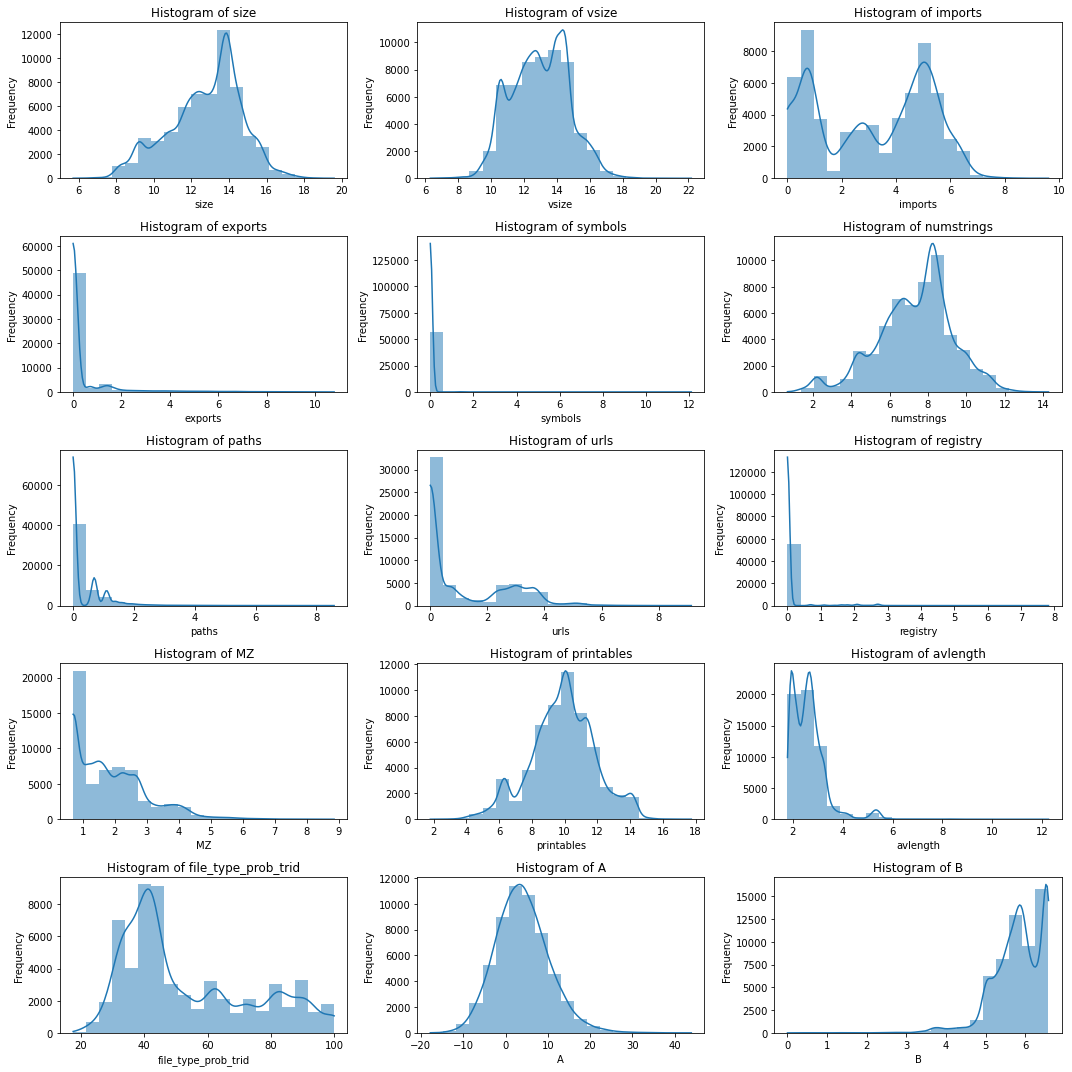

In [8]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
axes = axes.flatten()
sns.set_palette('muted')
for i, feature in enumerate(continuous_features):
    ax = axes[i]
    if feature == 'file_type_prob_trid' or feature == 'A' or feature == 'B':
        sns.histplot(train_data[feature], ax=ax, bins=20, edgecolor='none', kde=True, kde_kws={'bw_method': 0.15})
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.set_title('Histogram of {}'.format(feature))
    else:
        log_transformed_data = np.log1p(train_data[feature])
        sns.histplot(log_transformed_data, ax=ax, bins=20, edgecolor='none', kde=True, kde_kws={'bw_method': 0.15})
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.set_title('Histogram of {}'.format(feature))

plt.tight_layout()
plt.show()


We applied a `np.log` transformation to all continuous features expect `file_type_prob_trid`, `A`, and `B`, which showed skewness without it. This transformation helped us observe the distribution patterns more effectively. Notably, the majority of continuous features displayed skewness or non-bell-shaped distributions, except for the `A` feature, which showed a normal distribution.

The next step is to explore the partition of the **categorical features**:

In [9]:
n_unique = train_data[categorical_features].nunique()
print(f'Number of unique values in categorical features:\n{n_unique}')

Number of unique values in categorical features:
sha256            60000
file_type_trid       89
C                     7
dtype: int64


The `sha256` feature, which contains file names, is not informative in our dataset as each file has a unique name among the 60,000 values.<br>
`file_type_trid` which is the feature that corresponds to the file type with the highest probability has 89 unique values.
Let's plot the top 15:

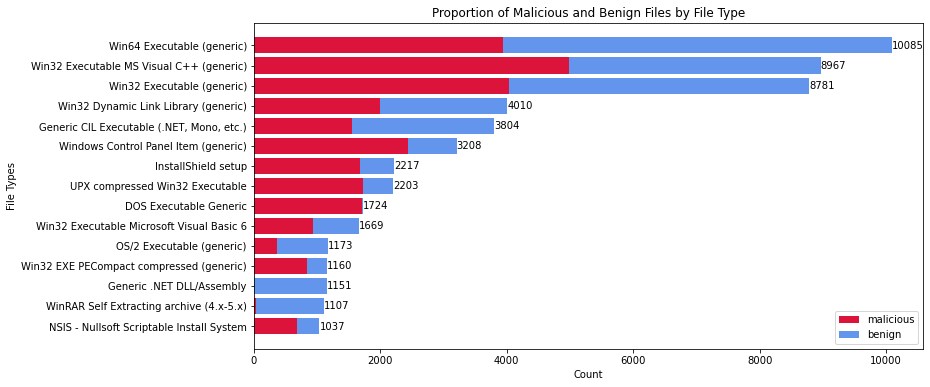

In [10]:
# Counts of each file type sorted in descending order
top_10_counts = train_data['file_type_trid'].value_counts().head(15)
top_10_counts = top_10_counts.iloc[::-1]  # Reverse the order

file_types = top_10_counts.index

# count label 1 and label 0 of each file type
label_1_counts = []
label_0_counts = []
for file_type in file_types:
    label_1_count = len(train_data[(train_data['file_type_trid'] == file_type) & (train_data['label'] == 1)])
    label_0_count = len(train_data[(train_data['file_type_trid'] == file_type) & (train_data['label'] == 0)])
    label_1_counts.append(label_1_count)
    label_0_counts.append(label_0_count)

fig, ax = plt.subplots(figsize=(12, 6))

# bars for each label counts
bar1 = ax.barh(file_types, label_1_counts, label='malicious', color='crimson')
bar2 = ax.barh(file_types, label_0_counts, left=label_1_counts, label='benign', color='cornflowerblue')

# Add total count labels above each bar
for i in range(len(file_types)):
    total_count = label_1_counts[i] + label_0_counts[i]
    ax.text(total_count, i, str(total_count), ha='left', va='center')

ax.set_xlabel('Count')
ax.set_ylabel('File Types')
ax.set_title('Proportion of Malicious and Benign Files by File Type')
ax.legend()
plt.show()


We notice a significant proportion of malicious files in the following file types: Windows Control Panel Item (generic), InstallShield setup, UPX compressed Win32 Executable, Win32 EXE PECompact compressed (generic), and NSIS - Nullsoft Scriptable Install System. <br>Additionally, **<span style="color:red;">almost 100% of malicious files were found in the DOS Executable Generic file type.</span>**


The `C` feature, an anonymous column, contains 7 distinct values worth exploring:

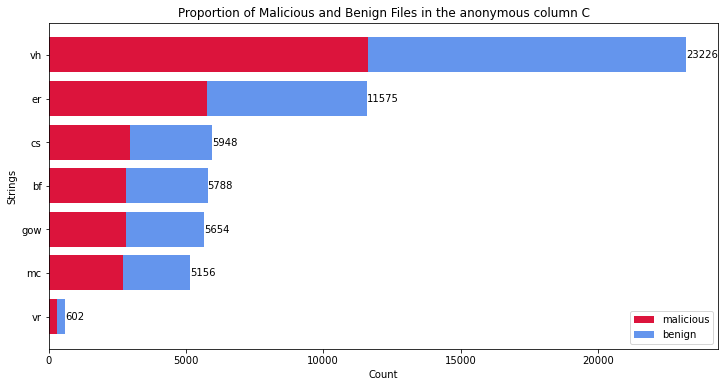

In [11]:
# Counts for each category
category_counts = train_data['C'].value_counts()
category_counts = category_counts.iloc[::-1]  # Reverse the order

categories = category_counts.index

label_1_counts = []
label_0_counts = []
for category in categories:
    label_1_count = len(train_data[(train_data['C'] == category) & (train_data['label'] == 1)])
    label_0_count = len(train_data[(train_data['C'] == category) & (train_data['label'] == 0)])
    label_1_counts.append(label_1_count)
    label_0_counts.append(label_0_count)

fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.barh(categories, label_1_counts, label='malicious', color='crimson')
bar2 = ax.barh(categories, label_0_counts, left=label_1_counts, label='benign', color='cornflowerblue')

for i in range(len(categories)):
    total_count = label_1_counts[i] + label_0_counts[i]
    ax.text(total_count, i, str(total_count), ha='left', va='center')

ax.set_xlabel('Count')
ax.set_ylabel('Strings')
ax.set_title('Proportion of Malicious and Benign Files in the anonymous column C')
ax.legend()
plt.show()

We can see that the string 'vh' appeared most frequently, while 'vr' was the least common. All of the strings were associated with approximately 50% of malicious files. Without further context we believe it is challenging to draw definitive conclusions.

Exploring the proportions of each **binary feature** in the data:

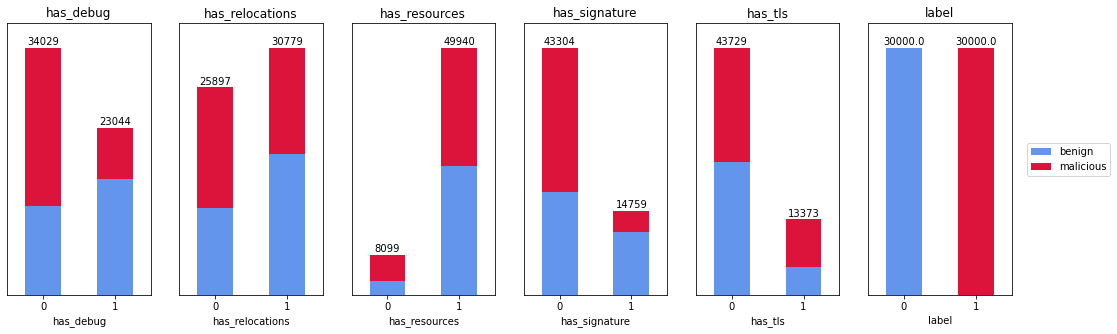

In [12]:
#BINARY FEATURES

fig, axs = plt.subplots(1, len(binary_features), figsize=(len(binary_features)*3, 5))

# Plot each binary feature
for i, feature in enumerate(binary_features):
    counts = train_data.groupby(feature)['label'].value_counts().unstack()
    counts.plot(kind='bar', stacked=True, ax=axs[i], title=feature, color=['cornflowerblue', 'crimson'])
    axs[i].set_ylim(0, counts.sum(axis=1).max()*1.1)
    axs[i].set_yticklabels([])
    axs[i].tick_params(axis='y', length=0)
    axs[i].set_xticklabels([int(tick) for tick in axs[i].get_xticks()])
    axs[i].tick_params(axis='x', rotation=0)
    axs[i].get_legend().remove()
    for j, count in enumerate(counts.sum(axis=1)):
        axs[i].text(j, count+counts.sum(axis=1).max()*0.01, str(count), ha='center')

handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, ['benign', 'malicious'], loc='center right', bbox_to_anchor=(0.98, 0.5))

plt.show()


From this plot, we observed some interesting insights about malicious files that we might got:<br>
- `has_debug`: Files with **no debug information** had a malicious presence exceeding 50%. This is often the case because malicious actors frequently attempt to remove or hide debug information in their files, making detection more challenging.

- `has_signature`: Files **without a digital signature** are more likely to be malicious, as legitimate files typically possess a digital signature.

- `has_tls`: Thread local storage (tls) used in executable files to allocate memory that is unique to each execution. Many legitimate executable files may include tls, but some **advanced malware techniques may also leverage tls** for their operations as we can see.

- `has_resources`: We detected big proportion of malicious files **without resources**. This observation may suggest that malicious actors intentionally remove resources from their files to make detection more challenging.

- `has_relocations`: Another indicator is files **without relocations** which can serve as additional of potential maliciousness.

**Features correlation**

Let's plot a heatmap to show the linear correlation between features:

<AxesSubplot:>

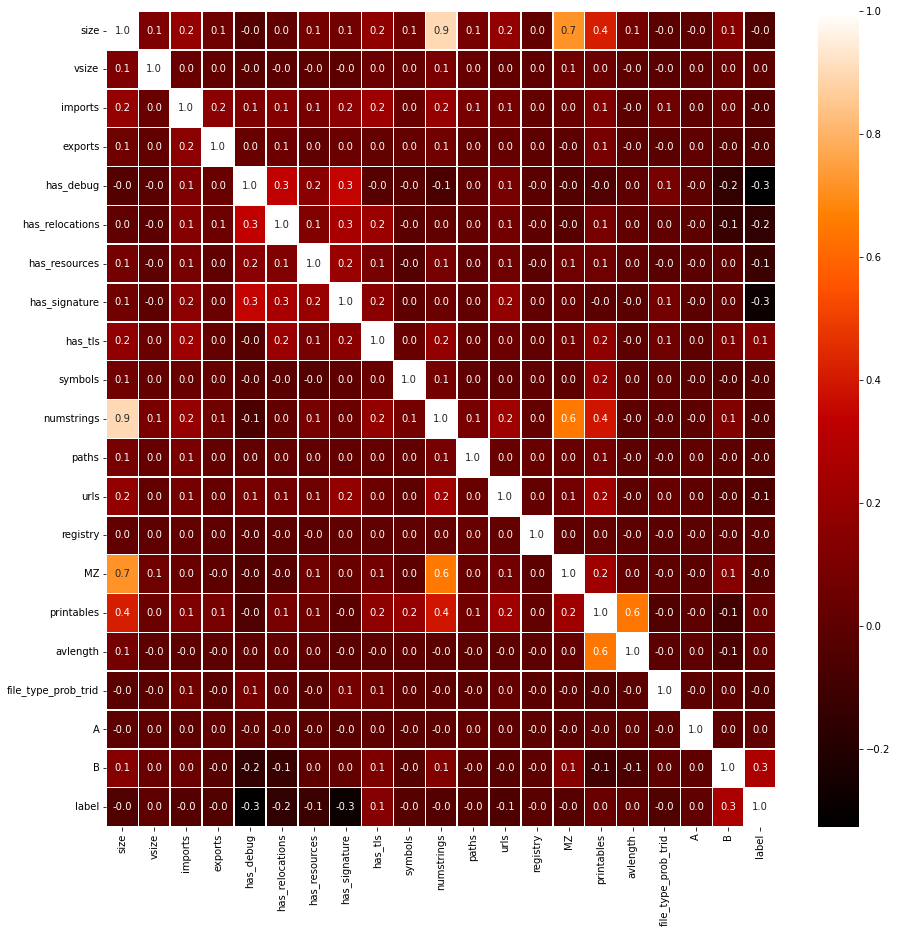

In [13]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap='gist_heat')

In [14]:
corr_size_numstrings = train_data['size'].corr(train_data['numstrings'])
print("Correlation between size and numstrings: ", corr_size_numstrings)

corr_MZ_size = train_data['MZ'].corr(train_data['size'])
print("Correlation between MZ and size: ", corr_MZ_size)

Correlation between size and numstrings:  0.8988105869260563
Correlation between MZ and size:  0.7159017755375064


We can see a strong positive correlation between `size` and the `numstrings`, as well as `MZ` with `size`.
The observed correlation between these variables makes sense, as an increase in the number of strings or the 'MZ' string, corresponds to an increase in the file size. During the preprocessing part, we made the decision not to remove any features in order to avoid information loss or overlook any potential nonlinear relationships.

## Part 2: Pre-processing

In [15]:
X = train_data.drop('label', axis=1)
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_y_train = pd.concat([X_train, y_train], axis=1)
X_y_val = pd.concat([X_val, y_val], axis=1)

In [16]:
print(f"Shape of the train dataset:{X_y_train.shape}")
print(f"Shape of the validation dataset:{X_y_val.shape}")

Shape of the train dataset:(48000, 24)
Shape of the validation dataset:(12000, 24)


**Investigating missing values**

Let's check the percentage of missing values for each feature:

In [17]:
def get_missing_values(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = ((total / len(df)) * 100).round(3).sort_values(ascending=False)
    missing_data = pd.concat([total, percentage], axis=1, keys=['Total','Percentage'])
    return missing_data

print(get_missing_values(X_y_train))

                     Total  Percentage
B                     2990       6.229
A                     2967       6.181
paths                 2932       6.108
has_relocations       2625       5.469
MZ                    2491       5.190
has_debug             2342       4.879
has_tls               2335       4.865
avlength              2224       4.633
printables            2202       4.588
numstrings            2177       4.535
symbols               2154       4.488
registry              2011       4.190
urls                  1868       3.892
exports               1669       3.477
C                     1639       3.415
has_resources         1577       3.285
vsize                 1564       3.258
has_signature         1522       3.171
imports               1366       2.846
sha256                   0       0.000
file_type_prob_trid      0       0.000
file_type_trid           0       0.000
size                     0       0.000
label                    0       0.000


19 out of 24 features have missing values, but the percentage of missing values for each feature is less than 6.3%, which is considered low. It is not necessary to delete any feature at this point, and we will handle the missing values properly later.<br> Let's also check the percentage of rows with missing values:

In [18]:
missing_rows_percent = X_y_train.isna().any(axis=1).sum() / len(X_y_train) * 100
print(f'\nPercentage of rows with missing values: {missing_rows_percent:.2f}%')


Percentage of rows with missing values: 58.10%


Well, having 58.1% of rows with missing values is too significant to simply remove. It's about time to address this issue!<br> Considering that our continuous features showed skewed distributions, we will fill the missing values with the **medians** of their respective columns, as this approach tends to perform better on skewed data. However, for the `A` feature, which follows a normal distribution, we can fill the missing values with the **mean** value of that column.

In [19]:
skewed_continuous_features = continuous_features[:-2]+continuous_features[-1:]
X_y_train[skewed_continuous_features] = X_y_train[skewed_continuous_features].fillna(X_y_train[skewed_continuous_features].median())

X_y_train['A'] = X_y_train['A'].fillna(X_y_train['A'].mean())

Let's check the missing values in the categorical features:

In [20]:
missing_rows_percent = X_y_train[categorical_features].isna().any(axis=1).sum() / len(X_y_train) * 100
print(f'\nPercentage of rows with missing values in categorical features: {missing_rows_percent:.2f}%')


Percentage of rows with missing values in categorical features: 3.41%


The presence of missing values in the categorical features is quite minimal. Given this circumstance, we have made the decision to remove these rows from the dataset. The rationale behind this choice is based on the fact that the percentage of missing values is relatively low, which implies that their impact on the overall dataset is minimal. 

In [21]:
X_y_train = X_y_train.dropna(subset=categorical_features)

Let's check the missing values in the binary features:

In [22]:
missing_rows_percent = X_y_train[binary_features].isna().any(axis=1).sum() / len(X_y_train) * 100
print(f'\nPercentage of rows with missing values in binary features: {missing_rows_percent:.2f}%')


Percentage of rows with missing values in binary features: 19.95%


We will fill the binary features missing values with the **most frequent value** of their column.

In [23]:
X_y_train[binary_features] = X_y_train[binary_features].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [24]:
missing_rows_percent = X_y_train.isna().any(axis=1).sum() / len(X_y_train) * 100
print(f'\nPercentage of rows with missing values: {missing_rows_percent:.2f}%')


Percentage of rows with missing values: 0.00%


We have now treated **all** the missing values.

**Normalization**<br>

We will apply the `PowerTransformer` using the `Yeo-Johnson` method on our unnormalized continuous features. This transformation is capable of handling both positive and negative values, and it adjusts our skewed or non-normal feature distributions to a Gaussian-like. Additionally, this transformation applies zero-mean, unit-variance normalization by defualt. This choice of transformation can might benefit our KNN model, which relies on distance-based calculations, as normalization reduces the impact of features with different scales.

In [25]:
for feature in continuous_features:
    pt = PowerTransformer(method='yeo-johnson')
    X_y_train[continuous_features] = pt.fit_transform(X_y_train[continuous_features])

**Outliers Detection**

The **IQR (Inter Quartile Range) method** identifies outliers by measuring the spread of the data using the IQR, which is the range between the first quartile<br>
($Q1$) and the third quartile ($Q3$).<br>

In our `outlier_count` function we implemented $(Q1–1.5*IQR)$ which represents the smallest value in the dataset, and $(Q3+1.5*IQR)$ which represents the largest value in the dataset. Any value beyond this range is considered an **outlier**. We used a bar plot to visualize the number of outliers for each feature, helping us make informed decisions on its proportions and how to adress them.

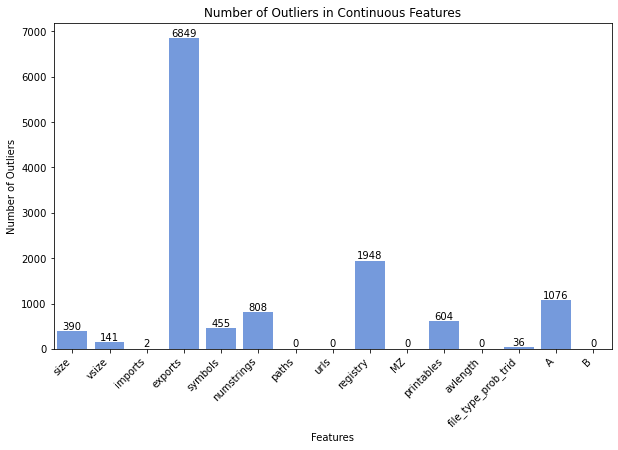

Total number of outliers in the dataset: 12309


In [26]:
def outlier_count(df):
    outlier_counts = {}
    
    for col in df.columns:
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25
        min_val = q25 - (iqr * 1.5)
        max_val = q75 + (iqr * 1.5)
        outlier_counts[col] = len(np.where((df[col] > max_val) | (df[col] < min_val))[0])
    
    return outlier_counts

# Calculate outlier counts for each feature
outlier_counts = outlier_count(X_y_train[continuous_features])

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=list(outlier_counts.keys()) ,y=list(outlier_counts.values()), color='cornflowerblue')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers in Continuous Features')
plt.xticks(range(len(outlier_counts.values())), list(outlier_counts.keys()), rotation=45, ha='right', va='top')
for x, y in enumerate(outlier_counts.values()):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.show()
print('Total number of outliers in the dataset:',sum(outlier_counts.values()))

We can observe a significant number of outliers in the `exports` feature and `registry`. The total amount of outliers accounts for approximately 25% of the samples, which indicates a presence of extreme values. To address this issue without losing valuable information, we can apply a technique called **Winsorization**.
It involves setting a confidence interval, typically 95%, and replacing values above the $95th$ percentile with the value at the $95th$ percentile, and values below the $5th$ percentile with the value at the $5th$ percentile. This technique helps to reduce the impact of outliers without completely removing them from the dataset.

In [27]:
def winsorize_continuous_features(df, features):
    df_winsorized = df.copy()
    for feature in features:
        df_winsorized[feature] = winsorize(df_winsorized[feature], limits=(0.05, 0.05))

    return df_winsorized

In [28]:
X_y_train = winsorize_continuous_features(X_y_train, continuous_features)

**Categorical features**

Let's have another look at the unique values of each categorical features after some changes:

In [29]:
n_unique = X_y_train[categorical_features].nunique()

print(f'Number of unique values in categorical features:\n{n_unique}')

Number of unique values in categorical features:
sha256            46361
file_type_trid       83
C                     7
dtype: int64


At this point we will drop the `sha256` feature as we already saw each file has its unique name and this information is not needed.

In [30]:
X_y_train = X_y_train.drop(['sha256'], axis=1)

`file_type_trid` has 83 unique values, which is a large number to use for One-Hot Encoding as each value would create another column. This would expand our data dimensions to over 100. To avoid the curse of dimensionality, we decided not to use One-Hot Encoding.<br> Instead, we employed the **Frequency Encoding** technique, where categorical variables are represented by their frequencies, ranging from 0 to 1.<br>
In this way, we aim to capture the relationship between different file types and whether they are malicious or not. By assigning the same value to files of the same type, we represent their belongingness and frequency.

In [31]:
freq = X_y_train['file_type_trid'].value_counts(normalize=True)
X_y_train['file_type_trid'] = X_y_train['file_type_trid'].map(freq)

Regarding the feature `C`, which has only 7 unique values, we applied **One-Hot Encoding**. This technique represents categorical variables as binary vectors. We implemented it without using the One-Hot Encoding class from the scikit-learn library.

In [32]:
C_values = X_y_train['C'].unique()
C_values_list = list(C_values)

for category in C_values_list:
    X_y_train[category]=np.where(X_y_train['C']==category,1,0)
C_values = X_y_train['C'].unique()
C_values_list = list(C_values)

for category in C_values_list:
    X_y_train[category]=np.where(X_y_train['C']==category,1,0).copy()

X_y_train = X_y_train.drop('C', axis=1)

**Feature engineering**

After encoding the values of the `file_type_trid` feature based on their belongingness and frequency, each file type is represented by a corresponding number. Additionally, we have the `file_type_prob_trid` feature, which indicates the probability of each file type. we created a new feature called `weighted_file_type` by multiplying each file type by its respective probability. **We create a weighted representation that takes into account both the categorical nature of the file type and its associated likelihood.** Then, we dropped `file_type_trid` and `file_type_prob_trid`.

In [33]:
X_y_train['weighted_file_type'] = X_y_train['file_type_trid'] * X_y_train['file_type_prob_trid']
X_y_train = X_y_train.drop(['file_type_trid','file_type_prob_trid'], axis=1)

**Dimensionality Reduction** 
## NOT PART OF THE FINAL PIPELINE

In [34]:
X_y_train.shape

(46361, 28)

At this stage, our dataset contains 28 features after completing all the preprocessing steps. However, we need to be cautious about the curse of dimensionality, which can arise in high-dimensional spaces. In such cases, the data points tend to spread out, making accurate predictions challenging. Additionally, overfitting becomes a concern as the models become more complex. This means that the models may perform well on the training data but struggle to generalize to new, unseen data.

We explored techniques like PCA (Principal Component Analysis) and backward selection to reduce dimensionality. However, **implementing these methods had a negative impact on the AUC scores of our models.** Thus, we made the decision not to proceed its implementation.
<br><font size=2>*We used the code we implemented in HW3</font><br>

In [35]:
def get_principal_components(X: np.array, p: float) -> np.array:

    pca = PCA(p)
    pca.fit(X)
    return pca.components_

In [36]:
# get components based on train set
train_components = get_principal_components(X_y_train.drop('label', axis=1),0.99)
train_data_pca = np.dot(X_y_train.drop('label', axis=1), train_components.T)
print(f'number of components which preserve at least 99% of the variance: {len(train_components)}')

number of components which preserve at least 99% of the variance: 21


**Test data treatment**

We created a copy of the test dataset to keep the file names and applied the same changes that were made earlier to the test and validation datasets.
<br><font size=2>*Categorical feature rows with missing values were filled with the most frequent value of their respective column, as its forbidden  to remove test samples.</font><br>

To simplify the process, we created a function to handle the preprocessing for both datasets:

In [37]:
X_y_test = test_data.copy()

def preprocess_data(test_data, continuous_features, categorical_features):

    # MISSING VALUES
    # Continuous
    skewed_continuous_features = continuous_features[:-2]+continuous_features[-1:]
    test_data[skewed_continuous_features] = test_data[skewed_continuous_features].fillna(test_data[skewed_continuous_features].median())
    test_data['A'] = test_data['A'].fillna(test_data['A'].mean())

    # Categorical
    imp = SimpleImputer(strategy='most_frequent')
    test_data[categorical_features] = imp.fit_transform(test_data[categorical_features])

    # Binary
    def fill_mode(x):
        if x.dtype == 'float':
            mode = x.mode()
            if not mode.empty:
                return x.fillna(mode.iloc[0])
        return x

    test_data = test_data.apply(fill_mode)

    # NORMALIZATION
    for feature in continuous_features:
        pt = PowerTransformer(method='yeo-johnson')
        test_data[continuous_features] = pt.fit_transform(test_data[continuous_features])

    # OUTLIERS
    test_data = winsorize_continuous_features(test_data, continuous_features)

    # CATEGORICAL FEATURES
    test_data = test_data.drop(['sha256'], axis=1)
    freq = test_data['file_type_trid'].value_counts(normalize=True)
    test_data['file_type_trid'] = test_data['file_type_trid'].map(freq)

    C_values = test_data['C'].unique()
    C_values_list = list(C_values)

    for category in C_values_list:
        test_data[category]=np.where(test_data['C']==category,1,0)
        
    C_values = test_data['C'].unique()
    C_values_list = list(C_values)

    for category in C_values_list:
        test_data[category]=np.where(test_data['C']==category,1,0).copy()

    test_data = test_data.drop('C', axis=1)

    #FEATURE ENGINEERING
    test_data['weighted_file_type'] = test_data['file_type_trid'] * test_data['file_type_prob_trid']
    test_data = test_data.drop(['file_type_trid', 'file_type_prob_trid'], axis=1)

    return test_data


In [38]:
X_y_val = preprocess_data(X_y_val, continuous_features, categorical_features)
X_y_test = preprocess_data(X_y_test, continuous_features, categorical_features)

We wanted to examine our tables after completing the preprocessing stage and before proceeding to the modeling stage, just to ensure that everything appears as expected.

In [39]:
X_y_val.head()

size     vsize   imports   exports  has_debug  has_relocations  \
3048  -0.293964 -0.293649  0.663676 -0.417197        0.0              0.0   
19563  0.565639  0.577671  1.187005 -0.417197        1.0              1.0   
58303  0.759837 -0.700400  0.792807 -0.417197        0.0              0.0   
8870  -0.043388 -0.026190  0.879279  2.396949        1.0              1.0   
40228  0.090876  0.106254  1.346771  2.396949        0.0              0.0   

       has_resources  has_signature  has_tls   symbols  numstrings     paths  \
3048             1.0            0.0      0.0 -0.095298   -0.296559 -0.581584   
19563            1.0            1.0      1.0 -0.095298    0.344425 -0.581584   
58303            1.0            0.0      1.0 -0.095298    0.786735 -0.581584   
8870             1.0            1.0      1.0 -0.095298   -0.107693  1.719441   
40228            1.0            1.0      0.0 -0.095298   -0.153274 -0.581584   

           urls  registry        MZ  printables  avlength         A         B  \
3048  -0.839372 -0.210896 -0.228255    0.056513 -0.199918 -0.014346  0.135750   
19563  1.191451 -0.210896  0.617059    0.740349  1.172181  0.956184 -0.116990   
58303  1.191138 -0.210896  1.331355    0.393249 -1.384963 -0.214287  1.515648   
8870   1.191438 -0.210896  0.243497   -0.027203  0.304616  0.064859 -0.102410   
40228  1.191392 -0.210896 -1.345051   -0.192377 -0.119098  0.090607 -0.289867   

       label  cs  vh  bf  gow  er  mc  vr  weighted_file_type  
3048       1   1   0   0    0   0   0   0           -0.068290  
19563      1   0   1   0    0   0   0   0            0.072779  
58303      1   0   0   1    0   0   0   0           -0.005292  
8870       0   0   1   0    0   0   0   0            0.009452  
40228      0   0   1   0    0   0   0   0           -0.136143

In [40]:
X_y_test.head()

size     vsize   imports   exports  has_debug  has_relocations  \
0  0.475130  0.952018 -1.001183 -0.400583        0.0              0.0   
1 -0.622992 -0.420460  0.850527 -0.400583        1.0              1.0   
2  1.183114 -0.731943  0.798955  2.496361        0.0              1.0   
3  0.625885  0.660303 -1.441341 -0.400583        1.0              1.0   
4  0.944636  0.971264  0.959707 -0.400583        0.0              0.0   

   has_resources  has_signature  has_tls   symbols  numstrings     paths  \
0            1.0            0.0      0.0 -0.103012    0.459178 -0.589754   
1            1.0            0.0      0.0 -0.103012   -0.792190  1.695622   
2            1.0            0.0      0.0 -0.103012    1.170380  1.695622   
3            1.0            0.0      0.0 -0.103012    0.734360 -0.589754   
4            1.0            0.0      0.0 -0.103012    0.269282  1.695622   

       urls  registry        MZ  printables  avlength         A         B  er  \
0 -0.838507 -0.210537  0.983574    0.059632 -1.563727 -0.856254  1.496942   1   
1 -0.838507 -0.210537  0.242321   -0.514926  0.923852  0.068625 -0.559706   0   
2 -0.838507 -0.210537  0.698689    1.049132 -0.039993 -0.914397  0.411945   0   
3 -0.838507 -0.210537 -0.638192    0.938820  0.807043  0.855235 -0.808556   0   
4 -0.838507 -0.210537 -0.638192    0.027721 -0.859078 -0.211753 -0.103221   1   

   cs  vh  gow  bf  mc  vr  weighted_file_type  
0   0   0    0   0   0   0           -0.050180  
1   1   0    0   0   0   0            0.005649  
2   0   1    0   0   0   0           -0.052334  
3   0   1    0   0   0   0           -0.171615  
4   0   0    0   0   0   0            0.036892

As we can observe, the columns in the validation and test dataset are in a different order. To address this, let's rearrange the columns in the test dataset to match the order of the columns in the train dataset:

In [41]:
train_columns = X_y_train.columns
X_y_val = X_y_val.reindex(columns=train_columns)
X_y_test = X_y_test.reindex(columns=train_columns)
X_y_test = X_y_test.drop('label', axis=1)

## Part 3: Models

In [42]:
X_train = X_y_train.drop('label', axis=1)
y_train = X_y_train['label']

X_val = X_y_val.drop('label', axis=1)
y_val = X_y_val['label']

We used `GridSearchCV` from scikit-learn to find the optimal hyperparameters for our **selected models: KNN, logistic regression, decision tree, and random forest.** The search was conducted using **5-fold cross-validation**, and the performance of the models was evaluated based on **AUC scores** calculated on the training data.

Before we run the models, let's explain the importance of each hyperparameters we chose to optimize:<br>

**KNN**
- `n_neighbors`: This hyperparameter determines the number of nearest neighbors the algorithm considers for classification. When choosing a small value for 'K,' the decision boundaries formed by the nearest neighbors can become more complex and overfitted to the training data. Consequently, the model may perform poorly on unseen data. On the other hand, with a larger value of 'K,' the decision boundaries become smoother and simpler. The model relies on a larger number of neighbors, which can sometimes result in misclassifications.

**Logistic Regression**
- `C`: controls the regularization strength, a smaller value of C increases the regularization strength (more regularization) resulting in a simpler model with potentially higher bias but lower variance. On the other hand, a larger value of C decreases the regularization strength, allowing the model to fit the training data more closely, which can lead to higher variance but lower bias (less regularization).

- `penalty`: determines the type of regularization used: `l1` (Lasso) or `l2` (Ridge).  the loss function of `l1` is modified by adding the absolute value and tends to set some coefficients to exactly zero- which makes it useful when there are many irrelevant features in our data.
`l2` encourages small, but non-zero, coefficient values. It helps to prevent overfitting by shrinking the coefficients towards zero without eliminating them entirely. It is generally more effective when all features contribute to the model and there is no need for explicit feature selection.

**Decision Tree**
- `max_depth`: This hyperparameter controls the maximum depth of the tree. By limiting the depth of the tree, we can prevent the model from overfitting to the training data. However, if the maximum depth is set too low, the model may underfit the data and have poor accuracy. By optimizing this hyperparameter, we can find the right balance between underfitting and overfitting.

- `min_samples_split`: This hyperparameter controls the minimum number of samples required to split an internal node. By increasing this value, we can prevent the tree from splitting on small or noisy groups of samples, which can help prevent overfitting. However, if this value is set too high, the tree may not be able to capture important patterns in the data. By optimizing this hyperparameter, we can find the right balance between underfitting and overfitting.

- `min_samples_leaf`: This hyperparameter controls the minimum number of samples required to be at a leaf node. By increasing this value, we can prevent the tree from creating leaves with very few samples, which can help prevent overfitting. However, if this value is set too high, the tree may not be able to capture important patterns in the data. By optimizing this hyperparameter, we can find the right balance between underfitting and overfitting.

**Random Forest**
- `n_estimators`: The hyperparameter n_estimators is the number of trees in the random forest. It is an important hyperparameter because it controls the complexity of the model. A larger number of trees can increase the accuracy of the model, but it can also increase the risk of overfitting and make the model slower to train and predict.

- `max_depth`: The max_depth parameter is the maximum depth of each decision tree in a random forest model. A larger max_depth reduces the bias but increases the variance of the model, which can lead to overfitting. A smaller max_depth reduces the variance but increases the bias of the model, which can lead to underfitting. The optimal max_depth is a trade-off between variance and bias, and depends on the characteristics of the data.

In [43]:
#MODELING
t0 = time.time() # for Runtime measurement

# Define our  models and their hyperparameters values
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {'n_neighbors': [3, 5, 7, 9, 11, 15, 19]}
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {'max_depth': [None, 5, 10, 20, 50], 'min_samples_split': [2, 5, 10, 16], 'min_samples_leaf': [1, 2, 5, 8]}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=0),
        'param_grid': {'n_estimators': [20, 50, 100, 200], 'max_depth':[10, 25, 40, 55]}
    },
}

best_models = {}

for model_name, model_info in models.items():
    # Extract the model and its hyper parameters
    model = model_info['model']
    param_grid = model_info['param_grid']
    
    # Perform grid search to find the best hyperparameters for the current model with respect to AUC scores
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    # Get the best model with its best hyperparameters
    best_model = grid_search.best_estimator_

    # Store the best model with its best hyperparameters
    best_models[model_name] = {
        'model': best_model,
        'best_params': grid_search.best_params_
    }
       
    print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")

print(f'Runtime: {round(time.time()-t0,2)} seconds')

Best hyperparameters for KNN: {'n_neighbors': 15}
Best hyperparameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}


Best hyperparameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best hyperparameters for Random Forest: {'max_depth': 25, 'n_estimators': 200}
Runtime: 1190.56 seconds


In [44]:
knn_best = best_models['KNN']['model']
lr_best = best_models['Logistic Regression']['model']
dt_best = best_models['Decision Tree']['model']
rf_best = best_models['Random Forest']['model']

models = [knn_best, lr_best, dt_best, rf_best]

for model in models:
    # Fit the best model with the best hyperparameters to the training data
    model.fit(X_train, y_train)

# Evaluate the best models on the validation set
knn_auc = roc_auc_score(y_val, knn_best.predict_proba(X_val)[:, 1])
lr_auc = roc_auc_score(y_val, lr_best.predict_proba(X_val)[:, 1])
dt_auc = roc_auc_score(y_val, dt_best.predict_proba(X_val)[:, 1])
rf_auc = roc_auc_score(y_val, rf_best.predict_proba(X_val)[:, 1])


print(f"AUC score for KNN on validation set: {knn_auc}")
print(f"AUC score for Logistic Regression on validation set: {lr_auc}")
print(f"AUC score for Decision Tree on validation set: {dt_auc}")
print(f"AUC score for Random Forest on validation set: {rf_auc}")

AUC score for KNN on validation set: 0.9360654610561027
AUC score for Logistic Regression on validation set: 0.8177983288873578
AUC score for Decision Tree on validation set: 0.8824615540611398
AUC score for Random Forest on validation set: 0.9687780292649592


## Part 4: Evaluation

**Confusion matrix**

We plotted the confusion matrix of our best Random Forest model, the results can be interpreted this way:

- **The top left cell (TN)** represents the number of True Negatives, which are the files that were correctly classified as non-malicious. This is the number of times the model correctly predicted the negative class.

- **The top right cell (FP)** represents the number of False Positives, which are the files that were incorrectly classified as malicious. This is the number of times the model predicted the positive class when it was actually negative.

- **The bottom left cell (FN)** represents the number of False Negatives, which are the files that were incorrectly classified as non-malicious. This is the number of times the model predicted the negative class when it was actually positive.

- **The bottom right cell (TP)** represents the number of True Positives, which are the files that were correctly classified as malicious. This is the number of times the model correctly predicted the positive class.


From this confusion matrix, we can calculate some performance metrics:

The accuracy of the model is 0.9054166666666666, this means that the model correctly classified 90.54166666666667% of the instances.

The precision of the model is 0.925814447592068, this means that when the model predicts a file is malicious, it is correct 92.5814447592068% of the time.

The recall of the model is 0.8795626576955424, this means that the model correctly identified 87.95626576955425% of the malicious files.

The F1-score of the model, which is a measure of balance between precision and recall, is 0.9020960924695937.


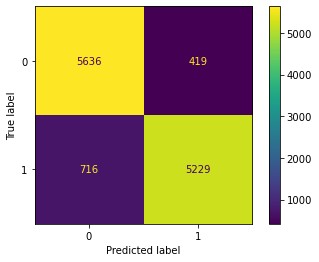

In [45]:
#CONFUSION MATRIX
y_pred = rf_best.predict(X_val)
conf_mat = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=rf_best.classes_)

disp.plot()

print("\nFrom this confusion matrix, we can calculate some performance metrics:")
TN, FP, FN, TP=conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"\nThe accuracy of the model is {accuracy}, this means that the model correctly classified {accuracy*100}% of the instances.")

precision = TP / (TP + FP)
print(f"\nThe precision of the model is {precision}, this means that when the model predicts a file is malicious, it is correct {precision*100}% of the time.")

recall = TP / (TP + FN)
print(f"\nThe recall of the model is {recall}, this means that the model correctly identified {recall*100}% of the malicious files.")

F1 = 2 * (precision * recall) / (precision + recall)
print(f"\nThe F1-score of the model, which is a measure of balance between precision and recall, is {F1}.")

**ROC curves for each of the 5 cross-validation folds**

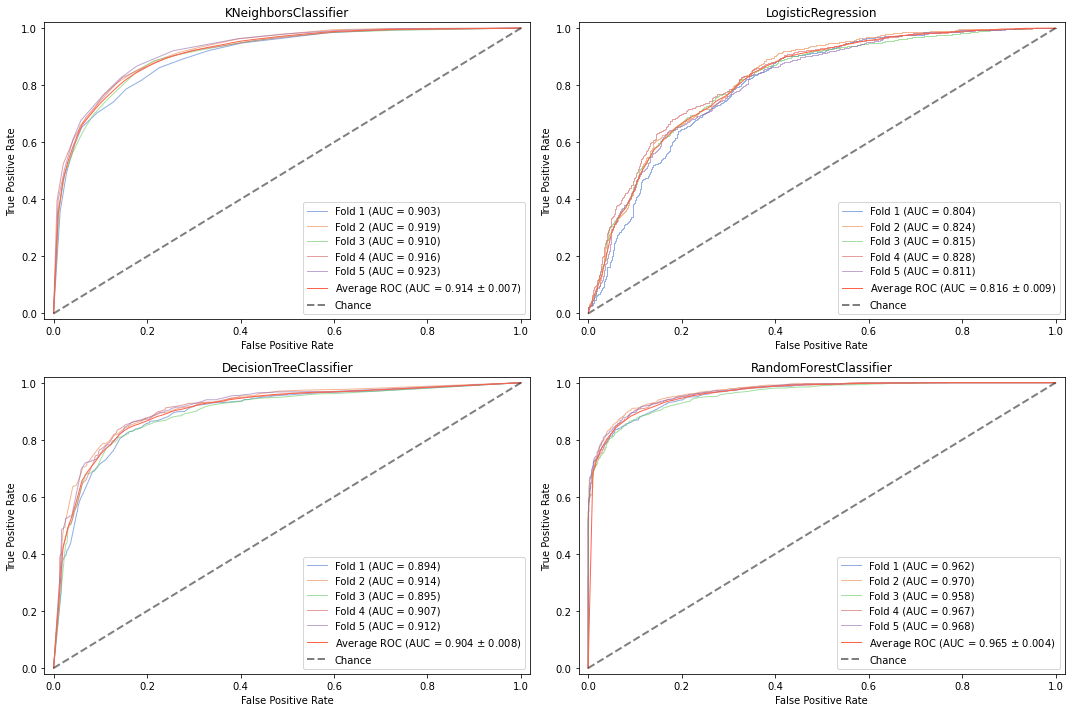

In [46]:
#ROC CURVES

def plot_roc_curves(models, X, y):
    cv = StratifiedKFold(n_splits=5)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for ax, model in zip(axes, models):
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []

        for i, (train, test) in enumerate(cv.split(X, y)):
            model.fit(X.iloc[train], y.iloc[train])
            y_pred_proba = model.predict_proba(X.iloc[test])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_proba)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            ax.plot(fpr, tpr, lw=1, alpha=0.6, label=f'Fold {i+1} (AUC = {roc_auc:.3f})')

        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        ax.plot(mean_fpr, mean_tpr, lw=1, color= 'tomato', label=f'Average ROC (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})')
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Chance', color='k', alpha=0.5)

        ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
               xlabel='False Positive Rate', ylabel='True Positive Rate',
               title=model.__class__.__name__)
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


models = [knn_best, lr_best, dt_best, rf_best]
plot_roc_curves(models, X_val, y_val)


We used **ROC curves** to evaluate our binary classifiers. The ROC curve illustrates the trade-off between the true positive rate (TPR), also known as sensitivity or recall, and the false positive rate (FPR), which represents the proportion of actual negative instances incorrectly classified as positive by the model. Our goal was to have ROC curves positioned as close as possible to the top-left corner of the plot, indicating high TPR and low FPR.

**We can see that the ROC of our Random Forest classifier performed better than other models.** Its curve is positioned closer to the top-left corner, indicating a better overall performance. The average AUC score for the Random Forest classifier is 96.5%.

**Train and validation performance evaluation**

In [47]:
# Comapring treain and validation AUC scores
train_knn_auc = roc_auc_score(y_train, knn_best.predict_proba(X_train)[:, 1])
train_lr_auc = roc_auc_score(y_train, lr_best.predict_proba(X_train)[:, 1])
train_dt_auc = roc_auc_score(y_train, dt_best.predict_proba(X_train)[:, 1])
train_rf_auc = roc_auc_score(y_train, rf_best.predict_proba(X_train)[:, 1])

print(f"AUC score for KNN on train set: {train_knn_auc}")
print(f"AUC score for KNN on validation set: {knn_auc}\n")

print(f"AUC score for Logistic Regression on train set: {train_lr_auc}")
print(f"AUC score for Logistic Regression on validation set: {lr_auc}\n")

print(f"AUC score for Decision Tree on train set: {train_dt_auc}")
print(f"AUC score for Decision Tree on validation set: {dt_auc}\n")

print(f"AUC score for Random Forest on train set: {train_rf_auc}")
print(f"AUC score for Random Forest on validation set: {rf_auc}")

AUC score for KNN on train set: 0.9138920728160449
AUC score for KNN on validation set: 0.9360654610561027

AUC score for Logistic Regression on train set: 0.8180194873835716
AUC score for Logistic Regression on validation set: 0.8177983288873578

AUC score for Decision Tree on train set: 0.8581391972133849
AUC score for Decision Tree on validation set: 0.8824615540611398

AUC score for Random Forest on train set: 0.9564433033051006
AUC score for Random Forest on validation set: 0.9687780292649592


The models showed better AUC scores on the validation dataset, indicating their ability to generalize well to new data.
To prevent **overfitting**, we focused on hyperparameter tuning using techniques like `GridSearchCV`. For instance, we used `penalty` arguments in logistic regression to apply regularization to the model's complexity and minimize overfitting. These efforts aimed to find a balance between model performance on the training data and its ability to generalize to unseen data.

**Feature importance**

We were curious about the most important features of our classifier, we can see that `weighted_file_type` has a significant impact.

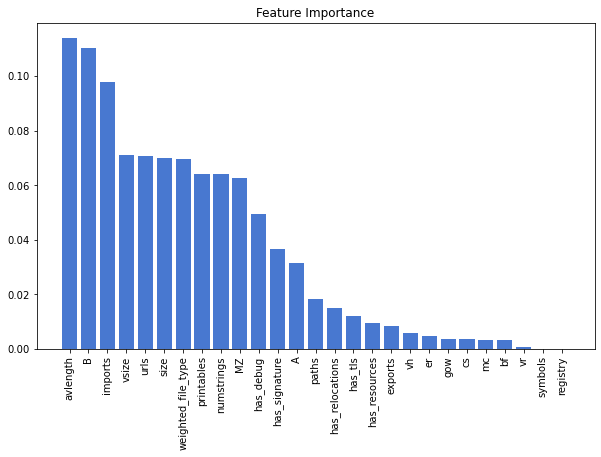

In [48]:
#FEATURE IMPORTANCE
importances = rf_best.feature_importances_
sorted_importances = importances[np.argsort(importances)[::-1]]
sorted_features = X_train.columns[np.argsort(importances)[::-1]]

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

## Part 5: Prediction

According to the results we got until now, the best model for our data is Random Forest.
We will use it to predict the labels of the test data.

In [49]:
#Splitting the data
train_data = pd.concat([X_y_train, X_y_val])
X = train_data.drop('label', axis=1)
y = train_data['label']

Now that we split the data, we'll predict the X_y_test labels and output the predictions into a CSV file, getting the files names from the test data as the order wasn't changed.

In [50]:
#Train our model on whole data
rf_best.fit(X, y)

y_pred = rf_best.predict(X_y_test)

# get the prediction probabilities
y_prob = rf_best.predict_proba(X_y_test)[:,1]

results = pd.DataFrame({'sha256': test_data['sha256'], 'predict_proba': y_prob})

# save the results to a CSV file
results.to_csv('results_39.csv', index=False)

**Pipeline**

In [51]:
from sklearn.pipeline import Pipeline

#Data loading
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv("test.csv")

#PRE-PROCESSING

#Splitting data
X = train_data.drop('label', axis=1)
y = train_data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_y_train = pd.concat([X_train, y_train], axis=1)
X_y_val = pd.concat([X_val, y_val], axis=1)

#Missing values
skewed_continuous_features = continuous_features[:-2]+continuous_features[-1:]
X_y_train[skewed_continuous_features] = X_y_train[skewed_continuous_features].fillna(X_y_train[skewed_continuous_features].median())
X_y_train['A'] = X_y_train['A'].fillna(X_y_train['A'].mean())
X_y_train = X_y_train.dropna(subset=categorical_features)
X_y_train = X_y_train.apply(lambda x: x.fillna(x.mode().iloc[0]) if x.dtype == 'float' else x)

#Normalization
for feature in continuous_features:
    pt = PowerTransformer(method='yeo-johnson')
    X_y_train[continuous_features] = pt.fit_transform(X_y_train[continuous_features])
    
#Outliers
X_y_train = winsorize_continuous_features(X_y_train, continuous_features)

#Categorical features
X_y_train = X_y_train.drop(['sha256'], axis=1)
freq = X_y_train['file_type_trid'].value_counts(normalize=True)
X_y_train['file_type_trid'] = X_y_train['file_type_trid'].map(freq)

C_values = X_y_train['C'].unique()
C_values_list = list(C_values)
for category in C_values_list:
    X_y_train[category]=np.where(X_y_train['C']==category,1,0)
C_values = X_y_train['C'].unique()
C_values_list = list(C_values)
for category in C_values_list:
    X_y_train[category]=np.where(X_y_train['C']==category,1,0).copy()
X_y_train = X_y_train.drop('C', axis=1)

#Feature engineering
X_y_train['weighted_file_type'] = X_y_train['file_type_trid'] * X_y_train['file_type_prob_trid']
X_y_train = X_y_train.drop(['file_type_trid','file_type_prob_trid'], axis=1)

#Test and validation pre-processing
X_y_test = test_data.copy()
X_y_val = preprocess_data(X_y_val, continuous_features, categorical_features)
X_y_test = preprocess_data(X_y_test, continuous_features, categorical_features)
train_columns = X_y_train.columns
X_y_val = X_y_val.reindex(columns=train_columns)
X_y_test = X_y_test.reindex(columns=train_columns)
X_y_test = X_y_test.drop('label', axis=1)

#MODELING PHASE

# Splitting data
X_train = X_y_train.drop('label', axis=1)
y_train = X_y_train['label']
X_val = X_y_val.drop('label', axis=1)
y_val = X_y_val['label']

# Hyperparameters estimation
models = {'Random Forest': {
        'model': RandomForestClassifier(random_state=0),
        'param_grid': {'n_estimators': [20, 50, 100, 200], 'max_depth':[10, 25, 40, 55]}}}
best_models = {}
for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['param_grid']
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[model_name] = {
        'model': best_model,
        'best_params': grid_search.best_params_
    }    

rf_best = best_models['Random Forest']['model']

          
#MODEL RUNNING
          
# Splitting the data
train_data = pd.concat([X_y_train, X_y_val])
X = train_data.drop('label', axis=1)
y = train_data['label']
rf_best.fit(X, y)
y_pred = rf_best.predict(X_y_test)
y_prob = rf_best.predict_proba(X_y_test)[:,1]
results = pd.DataFrame({'sha256': test_data['sha256'], 'predict_proba': y_prob})
results.to_csv('results_39.csv', index=False)

## Part 6

In this code, we used 2 techniques that we haven't seen in class:

- **PowerTransformer for normalization:**

PowerTransformer is a class from sklearn.preprocessing that applies a power transform featurewise to make data more Gaussian-like.

In our code, we used the default method of `yeo-johnson`, which can handle both positive and negative values as we saw that the feature A includes negative values, and applied it on our continous features. This technique can reduce the skewness and heteroscedasticity of the data.

We also used the default option of `standardize=True`, which means that after applying the power transform, the transformed data will have zero mean and unit variance. This technique can benefit our random forest model as it reduces the range and variance of the data, which can reduce the complexity and depth of the decision trees and prevent overfitting.

- **Winsorization for outliers treatment:**

Winsorization is a data preprocessing technique used to handle outliers in a dataset. It replaces extreme values in a dataset with less extreme values. To be more precise, this process involves identifying a percentile and setting any data point that falls above this percentile with its value. We chose to use this technique because we had around 25% of outliers that we didn't want to remove to avoid information loss.

Moreover, Winsorization can handle skewed data, as we observed skewness in most of our continuous features during the exploratory data analysis (EDA) phase. This technique doesn't assume normality or symmetry, which aligns with our dataset.

By applying Winsorization, our Random Forest classifier is affected by reducing the impact of outliers, and we didn't lose any samples in the process. 